# JAX PR4 Likelihoods Example

This notebook demonstrates how to use the JAX-ified Planck PR4 CMB likelihoods with both JAX and NumPy modes.

## Overview

We will:
1. Compute CMB power spectra at the Planck 2018 best-fit cosmology
2. Initialize the three likelihood classes (CamSpec, Hillipop, Lollipop)
3. Compute likelihoods in both JAX and NumPy modes
4. Include low-ℓ lognormal components
5. Compare performance and results


In [1]:
import os 
os.environ["JAX_PLATFORMS"]="cpu"
import numpy as np
import jax
jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp
import matplotlib.pyplot as plt
import time

# Import the JAX PR4 package
from jax_pr4 import CamSpecPR4, HillipopPR4, LollipopPR4
from jax_pr4.config import set_jax_enabled, get_jax_enabled

from classy import Class

print("JAX PR4 Likelihoods Example Notebook")
print("="*50)
print(f"JAX version: {jax.__version__}")
print(f"NumPy version: {np.__version__}")


JAX PR4 Likelihoods Example Notebook
JAX version: 0.4.33
NumPy version: 1.26.0


In [2]:
def generate_planck_bestfit_cls(ell_max=2500):
    """
    Generate CMB power spectra at Planck 2018 best-fit cosmology.
    
    This is a simplified model that captures the main features of the CMB power spectra.
    In practice, you would use CAMB, CLASS, or another Boltzmann code.
    """
    ell = np.arange(ell_max + 1)
    
    # Planck 2018 best-fit parameters (simplified)
    # These are approximate values for demonstration
    h = 0.6737  # Hubble parameter
    omega_b = 0.02237  # Baryon density
    omega_cdm = 0.1200   # Cold dark matter density
    A_s = 2.1e-9       # Scalar amplitude
    n_s = 0.9649       # Scalar spectral index
    tau = 0.0544       # Optical depth

    M = Class()
    M.set({'output': 'tCl,pCl,lCl', 
            "h":h, 
           "omega_b":omega_b, 
           "omega_cdm":omega_cdm,
           "A_s":A_s, 
            "n_s":n_s,
           "tau_reio":tau,
          'l_max_scalars': 2508,
          'lensing': 'yes', 
        # Neutrino parameters
        'N_ur': 2.0328,                 # Effective number of ultra-relativistic species
        'N_ncdm': 1,                    # Number of non-cold dark matter species (massive neutrinos)
        'm_ncdm': 0.06,                 # Sum of neutrino masses [eV]}
          })
    M.compute()
    cls_dict = M.lensed_cl()
    factor = M.T_cmb()**2
    ell_val = cls_dict["ell"]
    ClTT = cls_dict["tt"]*factor
    ClTE = cls_dict["te"]*factor
    ClEE = cls_dict["ee"]*factor
    
    
    return ClTT, ClTE, ClEE

# Generate the spectra
print("Generating CMB power spectra at Planck 2018 best-fit...")
ClTT, ClTE, ClEE = generate_planck_bestfit_cls(ell_max=2500)

# Create batch of size 1 for likelihood computation
ClTT_batch = ClTT[np.newaxis, :]
ClTE_batch = ClTE[np.newaxis, :]
ClEE_batch = ClEE[np.newaxis, :]

print(f"Generated spectra shapes: ClTT={ClTT_batch.shape}, ClTE={ClTE_batch.shape}, ClEE={ClEE_batch.shape}")


Generating CMB power spectra at Planck 2018 best-fit...
Generated spectra shapes: ClTT=(1, 2509), ClTE=(1, 2509), ClEE=(1, 2509)


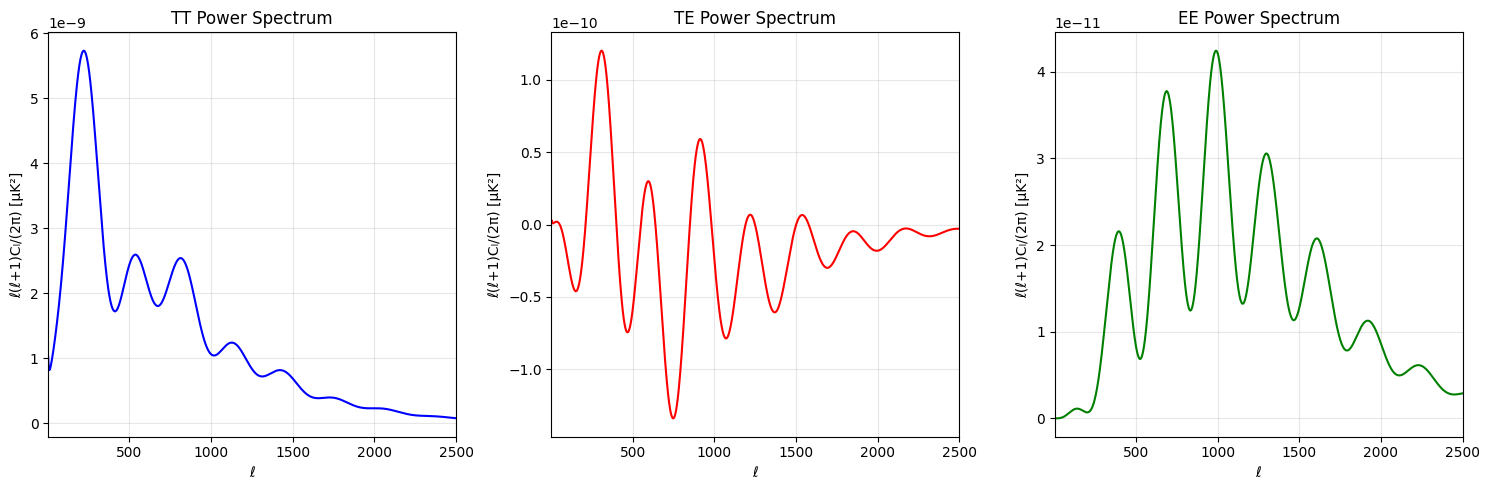

✓ CMB power spectra generated and plotted


In [3]:
# Plot the generated spectra
ell = np.arange(len(ClTT))
ell_factor = ell * (ell + 1) / (2 * np.pi)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# TT spectrum
axes[0].plot(ell[2:], ell_factor[2:] * ClTT[2:], 'b-', label='TT')
axes[0].set_xlabel('ℓ')
axes[0].set_ylabel('ℓ(ℓ+1)Cₗ/(2π) [μK²]')
axes[0].set_title('TT Power Spectrum')
axes[0].set_xlim(2, 2500)
axes[0].grid(True, alpha=0.3)

# TE spectrum
axes[1].plot(ell[2:], ell_factor[2:] * ClTE[2:], 'r-', label='TE')
axes[1].set_xlabel('ℓ')
axes[1].set_ylabel('ℓ(ℓ+1)Cₗ/(2π) [μK²]')
axes[1].set_title('TE Power Spectrum')
axes[1].set_xlim(2, 2500)
axes[1].grid(True, alpha=0.3)

# EE spectrum
axes[2].plot(ell[2:], ell_factor[2:] * ClEE[2:], 'g-', label='EE')
axes[2].set_xlabel('ℓ')
axes[2].set_ylabel('ℓ(ℓ+1)Cₗ/(2π) [μK²]')
axes[2].set_title('EE Power Spectrum')
axes[2].set_xlim(2, 2500)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ CMB power spectra generated and plotted")


## Step 2: Initialize Likelihood Classes

We'll initialize the three likelihood classes with placeholder configurations, including low-ℓ components.


In [4]:
# Initialize likelihood classes (placeholder mode)
print("Initializing likelihood classes...")
print()

# CamSpec with low-ell TT and EE
print("1. Initializing CamSpec with low-ell components...")
camspec_config = {
    'add_lowell': True,  # Include both low-ell TT and EE lognormal bins
    'apply_planck_temperature_rescaling': False,
    'apply_planck_pol_rescaling': False,
}
camspec = CamSpecPR4(additional_args=camspec_config)
print()

# Hillipop with low-ell TT only
print("2. Initializing Hillipop with low-ell TT...")
hillipop_config = {
    'add_lowl_tt': True,  # Include low-ell TT lognormal bins
    'tsz_template': 'planck',
}
hillipop = HillipopPR4(additional_args=hillipop_config)
print()

# Lollipop (low-ell EE, BB, EB)
print("3. Initializing Lollipop...")
lollipop_config = {
    'mode': 'lowlE',  # EE only for this example
}
lollipop = LollipopPR4(additional_args=lollipop_config)
print()

print("✓ All likelihood classes initialized successfully")


Initializing likelihood classes...

1. Initializing CamSpec with low-ell components...
✓ CamSpec data loaded: 9915 data points
  Covariance matrix shape: (9915, 9915)
  Foreground array size: 2501
✓ Low-ell data loaded successfully
CamSpec PR4 likelihood initialized successfully!

2. Initializing Hillipop with low-ell TT...
Define multipole ranges
Reading cross-spectra
Reading cross-spectra
Covariance matrix file: /cluster/work/refregier/alexree/local_packages/jax_pr4/data/planck_pr4_hillipop/invfll_PR4_v4.2_TTTEEE.fits
Adding 'dust_model' foreground for TT
Adding 'tsz' foreground for TT
Adding 'ksz' foreground for TT
Adding 'cib' foreground for TT
Adding 'szxcib' foreground for TT
Adding 'ps_radio' foreground for TT
Adding 'ps_dusty' foreground for TT
Adding 'dust_model' foreground for EE
Adding 'dust_model' foreground for TE
Initialized!

3. Initializing Lollipop...
NBINS 29
LMAX 30
Reading model
Reading covariance
Compute offsets
Initialized!

✓ All likelihood classes initialized su

## Step 3: Compute Likelihoods in Both JAX and NumPy Modes

We'll compute the likelihoods using both JAX and NumPy arrays to demonstrate the dual-mode functionality.


In [ ]:
# Define nuisance parameters
# Define nuisance parameters
camspec_params = {
    'A_planck': jnp.array([1.0]), 'calTE': jnp.array([1.0]), 'calEE': jnp.array([1.0]), 'n_143': jnp.array([1.0]), 'n_143x217': jnp.array([1.0]), 'n_217': jnp.array([1.0]), 
    'amp_143':jnp.array([1.0]), 'amp_143x217':jnp.array([1.0]), 'amp_217':jnp.array([1.0])
}

hillipop_params = {
    'A_planck': jnp.array([1.0]),
    # Calibration parameters
    'cal100A': jnp.array([1.0]), 'cal100B': jnp.array([1.0]), 
    'cal143A': jnp.array([1.0]), 'cal143B': jnp.array([1.0]), 
    'cal217A': jnp.array([1.0]), 'cal217B': jnp.array([1.0]),
    'pe100A': jnp.array([1.0]), 'pe100B': jnp.array([1.0]), 
    'pe143A': jnp.array([1.0]), 'pe143B': jnp.array([1.0]), 
    'pe217A': jnp.array([1.0]), 'pe217B': jnp.array([1.0]),
    # Temperature rescaling (if enabled)
    'm_t_hillipop': jnp.array([0.0]), 'm_e_hillipop': jnp.array([0.0]),
    # Dust parameters (TT mode)
    'AdustT': jnp.array([1.0]), 'AdustP': jnp.array([1.0]), 'Adusty': jnp.array([1.0]),
    'beta_dustT': jnp.array([1.5]), 'beta_dustP': jnp.array([1.5]),
    # Synchrotron parameters
    'AsyncT': jnp.array([1.0]), 'AsyncP': jnp.array([1.0]),
    # Point source parameters
    'Aps100': jnp.array([1.0]), 'Aps143': jnp.array([1.0]), 'Aps217': jnp.array([1.0]),
    'Aradio':jnp.array([1.0]), 'beta_radio': jnp.array([-0.7]), 'beta_dusty': jnp.array([1.75]),
    # CIB parameters
    'Acib': jnp.array([1.0]), 'beta_cib': jnp.array([1.75]),
    # SZ parameters
    'Atsz': jnp.array([1.0]), 'beta_tsz': jnp.array([0.0]),
    'Aksz': jnp.array([1.0]), 'xi': jnp.array([1.0]),
}

lollipop_params = {'A_planck': jnp.array([1.0])}

print("Computing likelihoods in NumPy and JAX modes...")
print("="*60)

# NumPy mode
print("NumPy Mode:")
set_jax_enabled(False)
start_time = time.time()

loglike_camspec_numpy = camspec.compute_like(ClTT_batch, ClTE_batch, ClEE_batch, camspec_params)
loglike_hillipop_numpy = hillipop.compute_like(ClTT_batch, ClTE_batch, ClEE_batch, hillipop_params)
loglike_lollipop_numpy = lollipop.compute_like(ClEE_batch, params=lollipop_params)

numpy_time = time.time() - start_time
print(f"  CamSpec: {loglike_camspec_numpy[0]:.6f}")
print(f"  Hillipop: {loglike_hillipop_numpy[0]:.6f}")
print(f"  Lollipop: {loglike_lollipop_numpy[0]:.6f}")
print(f"  Total time: {numpy_time*1000:.2f} ms")
print()

# JAX mode
print("JAX Mode:")
set_jax_enabled(True)
ClTT_jax = jnp.array(ClTT_batch)
ClTE_jax = jnp.array(ClTE_batch)
ClEE_jax = jnp.array(ClEE_batch)


jit_camspec_compute_like = jax.jit(camspec.compute_like)
jit_hillipop_compute_like = jax.jit(hillipop.compute_like)
jit_lollipop_compute_like = jax.jit(lollipop.compute_like)

# call once to compile -- one at a time for memory 
jit_camspec_compute_like(ClTT_jax, ClTE_jax, ClEE_jax, camspec_params)
jit_hillipop_compute_like(ClTT_jax, ClTE_jax, ClEE_jax, hillipop_params)
jit_lollipop_compute_like(ClTT_jax, ClTE_jax, ClEE_jax, hillipop_params)

start_time = time.time()

loglike_camspec_jax = jit_camspec_compute_like(ClTT_jax, ClTE_jax, ClEE_jax, camspec_params)
loglike_hillipop_jax = jit_hillipop_compute_like(ClTT_jax, ClTE_jax, ClEE_jax, hillipop_params)
loglike_lollipop_jax = jit_lollipop_compute_like(ClTT_jax, ClTE_jax, ClEE_jax, hillipop_params)

jax_time = time.time() - start_time
print(f"  CamSpec: {float(loglike_camspec_jax[0]):.6f}")
print(f"  Hillipop: {float(loglike_hillipop_jax[0]):.6f}")
print(f"  Lollipop: {float(loglike_lollipop_jax[0]):.6f}")
print(f"  Total time: {jax_time*1000:.2f} ms")

# Comparison
print("Comparison:")
# print(f"  Results consistent: {np.allclose([loglike_camspec_numpy[0]], [float(loglike_camspec_jax[0])])}")

print(f"  Results consistent: {np.allclose([loglike_camspec_numpy[0], loglike_hillipop_numpy[0], loglike_lollipop_numpy[0]], [float(loglike_camspec_jax[0]), float(loglike_hillipop_jax[0]), float(loglike_lollipop_jax[0])])}")
print("time speed up", numpy_time/jax_time)
print("✓ Both modes completed successfully")


Computing likelihoods in NumPy and JAX modes...
NumPy Mode:
IS JAX: False
lowell
XSHAPE 29
  CamSpec: -5979.241336
  Hillipop: -18693.558594
  Lollipop: -33.101884
  Total time: 1132.61 ms

JAX Mode:
using jax
IS JAX: True
lowell


### Lets look at gradients 
*  firstly lets work out what we want the gradients with respect to - we can talk gradients wrt any input but as nuisance params are a dict we would need to write a pure function wrapper to get these derivatives!
*  we will set this up for Camspec as an example
*  note cosmo params can be easily included in such a wrapper proided one has a `JAX`-Boltzmann solver 

In [ ]:
camspec_nuisance_names = list(camspec_params.keys())
def wrapped_like_func(params):
    camspec_nuisance_params = {camspec_nuisance_names[i]:params[i] for i in range(len(camspec_nuisance_names))}
    return jit_camspec_compute_like(ClTT_jax, ClTE_jax, ClEE_jax, camspec_nuisance_params)[0] #make this a scalar output so we can use grad (otherwise use jacobian methods for batches!)

grad_campsec_like = jax.grad(wrapped_like_func)

In [ ]:
gradients = grad_campsec_like(jnp.array(list(camspec_params.values())))

In [ ]:
print(gradients)

### Compressed Hillipop likelihood 

* As described in Reeves et al., 2025 we also implement a binning scheme for the `Hillipop` likelihood to reduce the number of data points whilst preserving cosmological information
* To use the binned version of the likelihood the set-up is very simple one just needs to add the folowing additional_args:

In [ ]:
binning_matrix = jnp.array(np.load("./data/planck_pr4_hillipop/binning_matrix.npy", allow_pickle=True).item().toarray())
binned_invkll = jnp.array(np.load("./data/planck_pr4_hillipop/binned_invkll.npy"))

In [ ]:
print("Initializing binned Hillipop with low-ell TT...")
hillipop_config = {
    'add_lowl_tt': True,  # Include low-ell TT lognormal bins
    'tsz_template': 'planck',
    'binning_matrix':binning_matrix, 
    'binned_invkll':binned_invkll
}
hillipop_binned = HillipopPR4(additional_args=hillipop_config)
print("binned likelihood class created")

In [ ]:
# calling the likelihood works in exactly the same way!
hillipop_binned.compute_like(ClTT_batch, ClTE_batch, ClEE_batch, hillipop_params)